In [2]:
import sys
from pathlib import Path
from datetime import datetime
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy import stats
from scipy import optimize
from scipy import signal
from statsmodels.tsa.stattools import acf
from statsmodels.formula.api import ols

sys.path.append('../../../Research/Flux Pipeline Project/Platinum_EC/src/python')
from ecprocessor.tiltcorrections import *
from ecprocessor.utils import *

In [3]:
# directories specific to Alex's computer
EC_7m_dir = Path('../../../../../Project_Data/Platinum_EC/BB-SF/EC/7m/Converted')

Wilczak et al 2001 (Wilczak et al., 2001) outlines a couple methods for quantifying flux uncertainty due to coordinate rotations. For the double- and triple-rotation schemes, we can estimate uncertainty in heat flux as follows. In this example, only one tilt angle (elevation $\phi$) is applied.

This equation describes how measured heat flux changes when rotating by an angle \phi in the xz-plane, where $\overline{uT}$ is estimated from Monin-Obukhov similarity theory for an unstable stratification:

$$
\begin{align}
\overline{w_{m}T_{m}}	&=\overline{wT}\cos\phi-\overline{uT}\sin\phi \\
&=\overline{wT}\left(\cos\phi-5.13(1-19L)^{-1/4}(1-12z/L)^{-1/2}\sin\phi\right)
\end{align}
$$

$\overline{wT}$ is the “true” flux expressed in the rotated coordinate frame. This gives, for the 7m tower at the severe fire site at Chimney Park:
$$\overline{wT}=\overline{w_{m}T_{m}}/\left(\cos\phi+b\sin\phi\right)where b ranges from -0.25 (L\ll0) to -0.55 (L\lesssim0).$$
This then gives us an uncertainty in the true heat flux due to uncertainties in the tilt angle $\phi$:
$$
\begin{align}
\epsilon_{wT}^{2}	&=\left(\frac{\partial\overline{wT}}{\partial\phi}\epsilon_{\phi}\right)^{2} \\
	&=\overline{w_{m}T_{m}}\frac{\sin\phi-b\cos\phi}{\left(\cos\phi+b\sin\phi\right)^{2}}\epsilon_{\phi}
\end{align}
$$

Additionally, the author identifies errors in \phi due to uncertainty in w:
##\epsilon_{\phi}=\arcsin(\epsilon_{\bar{w}}/\bar{u})$$

Where the standard error of the mean of w is determined by the effective sample size of w within the averaging window, which is assumed to depend on the measurement height, windspeed, and measurement window. The author suggests that the number of independant samples decreases by a factor of ~5 in unstable conditions (Kaimal et al, 1972):
$$\epsilon_{\bar{w}}=\frac{\sigma_{w}}{\sqrt{N_{eff}}}\approx\sqrt{\frac{5f\bar{u}}{nz}}\sigma_{w}$$

where n is the number of samples (18000), z is the measurement height (7m) and f is the sampling frequency (10Hz). This gives a final uncertainty in heat flux of 
$$\epsilon_{wT}=\overline{w_{m}T_{m}}\frac{\sin\phi-b\cos\phi}{\left(\cos\phi+b\sin\phi\right)^{2}}\arcsin\left(\sqrt{\frac{5fz}{n\bar{u}}}\sigma_{w}\right)$$

Another method would be to apply the planar fit method, also from Wilczak (2001), and propogate the uncertainties in the planar fit coefficients

Below is my code for implementing these methods. I implemented a different planar fit calculation here. Originally, I computed the planar fit approximation using a fourier series fit $\phi(\theta)$ (Ross and Grant, 2015), and "bootstrapped" the uncertainties. In Ross and Grant (2015), $\phi$ is the zenith angle in the direction of the mean 30-minute wind velocity with cardinal direction $\theta$. The method from Wilczak (2001) instead uses a bilinear regression to determine a global angle $\beta$. 

I found Wilczak's method to be a little strange for computing the number of independent samples per averaging period, so I also implemented a method to compute it using the autocorrelation coefficient:

$$ x_i = ax_{i-1} + b\varepsilon \\ 
b = \sqrt{1 - a^2} \\
\varepsilon \sim \mathrm{Norm}(\mu=0, \sigma=1) \\ 
N_{eff}\approx -N\log(a)/2,$$
where $x$ is a standardized dataset of size $N$.

To compute $LE$, I only used the planar fit method, not Wilczak's explicit method that I use for double rotations, since I did not look up how $\overline{w'\rho_v'}$ and $\overline{u'\rho_v'}$ were related, which is needed for that method.

I will use data from the 7m severe fire tower at Chimney Park from November 2022 for this.

In [4]:
# record file timestamps and paths
EC_7m_fast_fns = list(EC_7m_dir.glob('TOA5*10Hz*dat'))
EC_7m_df = pd.DataFrame(dict(fn=EC_7m_fast_fns))
EC_7m_df['TIMESTAMP'] = [get_timestamp_from_fn(fn, prefix_regex=r'^TOA5.*10Hz[0-9]+_', suffix_regex=r'\.dat$') for fn in EC_7m_df['fn']]
EC_7m_df = EC_7m_df.sort_values('TIMESTAMP').set_index('TIMESTAMP')

EC_7m_df = EC_7m_df

In [5]:

# compute summary statistics by looping through data files
renaming_dict=dict(
    Ux_CSAT3B='U',
    Uy_CSAT3B='V',
    Uz_CSAT3B='W',
    Ts_CSAT3B='Ts',
    rho_c_LI7500='CO2',
    rho_v_LI7500='H2O',
    P_LI7500='P'
)

b = -0.4
f = 10
n = 18000
z = 7

H_wilczak = np.empty(EC_7m_df.shape[0])
H_pf = np.empty(EC_7m_df.shape[0])
LE_wilczak = np.empty(EC_7m_df.shape[0])
LE_pf = np.empty(EC_7m_df.shape[0])

eps_H_wilczak = np.empty(EC_7m_df.shape[0])
eps_LE_wilczak = np.empty(EC_7m_df.shape[0])
eps_H_pf = np.empty(EC_7m_df.shape[0])
eps_LE_pf = np.empty(EC_7m_df.shape[0])


Cov_WmTm = np.empty(EC_7m_df.shape[0])
Cov_We_pf = np.empty(EC_7m_df.shape[0])
Cov_WT_wilczak = np.empty(EC_7m_df.shape[0])
eps_phi_wilczak = np.empty(EC_7m_df.shape[0])
eps_WT_wilczak = np.empty(EC_7m_df.shape[0])
eps_phi_wilczak_acf = np.empty(EC_7m_df.shape[0])
eps_WT_wilczak_acf = np.empty(EC_7m_df.shape[0])
eps_We_pf = np.empty(EC_7m_df.shape[0])
theta, phi = np.empty(EC_7m_df.shape[0]), np.empty(EC_7m_df.shape[0])
U, V, W = np.empty(EC_7m_df.shape[0]), np.empty(EC_7m_df.shape[0]), np.empty(EC_7m_df.shape[0])


In [6]:

#### Double rotation method
for i, fn in enumerate(tqdm(EC_7m_df['fn'])):
    # read in data
    dat = (
        pd.read_csv(fn, skiprows=[0, 2, 3], parse_dates=['TIMESTAMP'])
        .rename(columns=renaming_dict)
    )
    # get air density etc needed for heat flux calculations
    rho = (dat['P']*1000/(287*(dat['Ts'] + 273.15))).mean()
    cp = 1003 
    lv = 2260e3

    w_std = dat.W.std()
    u_bar = np.sqrt(dat.U**2 + dat.V**2).mean()
    
    # compute double rotation angles
    theta[i], phi[i] = get_double_rotation_angles(dat.U.mean(), dat.V.mean(), dat.W.mean())

    # covariance
    Cov_WmTm[i] = np.cov(dat.W, dat.Ts)[0, 1]

    # wilczak method: eq 14, 34
    Cov_WT_wilczak[i] = Cov_WmTm[i]/(np.cos(phi[i]) + b*np.sin(phi[i]))
    eps_w_wilczak = np.sqrt(5*f*u_bar/(n*z))*w_std
    eps_phi_wilczak[i] = np.arcsin(eps_w_wilczak/u_bar)
    eps_WT_wilczak[i] = np.abs(Cov_WmTm[i]*(np.sin(phi[i]) - b*np.cos(phi[i]))/(np.cos(phi[i]) + b*np.sin(phi[i]))**2*eps_phi_wilczak[i])

    # alternate method for finding N_eff: approximate W as an AR1 timeseries
    # find autocorrelation coefficient to get effective sample size
    N_eff = -n*np.log(acf(dat.W)[1])/2 - 1
    eps_w_wilczak_acf = np.sqrt(1/N_eff)*w_std
    eps_phi_wilczak_acf[i] = np.arcsin(eps_w_wilczak_acf/u_bar)
    eps_WT_wilczak_acf[i] = np.abs(Cov_WmTm[i]*(np.sin(phi[i]) - b*np.cos(phi[i]))/(np.cos(phi[i]) + b*np.sin(phi[i]))**2*eps_phi_wilczak_acf[i])

    H_wilczak[i] = Cov_WT_wilczak[i]*rho*cp
    eps_H_wilczak[i] = eps_WT_wilczak[i]*rho*cp

    U[i], V[i], W[i] = dat.U.mean(), dat.V.mean(), dat.W.mean()



dat = pd.DataFrame(dict(U=U, V=V, W=W))

100%|██████████| 671/671 [00:29<00:00, 22.66it/s]


In [7]:

#### Planar fit Method
# use eq'ns 2, 35, 36, 40, 45, 46 from Wilczak 2001
def get_M(b0, b1, b2, U, V, W):
    # eq 40
    alpha = np.arctan(-b1)
    beta = np.arctan(b2)

    # eq 2
    C = np.array([
        [1, 0, 0],
        [0, np.cos(beta), -np.sin(beta)],
        [0, np.sin(beta), np.cos(beta)]
    ])
    D = np.array([
        [np.cos(alpha), 0, np.sin(alpha)],
        [0, 1, 0],
        [-np.sin(alpha), 0, np.cos(alpha)]
    ])

    # eq 36
    P = D.T @ C.T

    # apply fit plane: eq 35
    uvw = np.stack((U, V, W), axis=1)
    uvw_p = np.array([P@uvw[i, np.newaxis].T for i in range(uvw.shape[0])])[:, :, 0].T
    Up, Vp, Wp = uvw_p[0, :], uvw_p[1, :], uvw_p[2, :]

    # rotate into mean wind direction: eq 46
    gamma = np.arctan(Vp/Up)
    # eq 45
    M = np.array([
        [np.cos(gamma), np.sin(gamma), np.zeros_like(gamma)],
        [-np.sin(gamma), np.cos(gamma), np.zeros_like(gamma)],
        [np.zeros_like(gamma), np.zeros_like(gamma), np.ones_like(gamma)]
    ])

    return M, P, gamma, beta

# eq 39
# data are autocorrelated with a coefficient of ~0.8, so scale appropriately
model = ols('W ~ U + V', dat).fit()
b0, b1, b2 = model.params
bse0, bse1, bse2 = model.bse
N_eff = -model.df_resid*np.log(acf(dat.W)[1])/2 - 1
bse0 *= np.sqrt(model.df_resid/N_eff)
bse1 *= np.sqrt(model.df_resid/N_eff)
bse2 *= np.sqrt(model.df_resid/N_eff)
print(np.sqrt(model.df_resid/N_eff))

M_high, P_high, _, _ = get_M(b0 + bse0, b1 + bse1, b2 + bse2, U, V, W)
M, P, _, _ = get_M(b0, b1, b2, U, V, W)
M_low, P_low, _, _ = get_M(b0 - bse0, b1 - bse1, b2 - bse2, U, V, W)

Cov_WT_pf = np.empty(EC_7m_df.shape[0])
eps_WT_pf = np.empty(EC_7m_df.shape[0])
for i, fn in enumerate(tqdm(EC_7m_df['fn'])):
    iM_high = M_high[:, :, i]@P_high
    iM = M[:, :, i]@P
    iM_low = M_low[:, :, i]@P_low
    dat = (
        pd.read_csv(fn, skiprows=[0, 2, 3], parse_dates=['TIMESTAMP'])
        .rename(columns=renaming_dict)
    )
    # get air density etc needed for heat flux calculations
    rho = (dat['P']*1000/(287*(dat['Ts'] + 273.15))).mean()
    cp = 1003 
    lv = 2260e3

    uvw_final_high = (iM_high @ dat[['U', 'V', 'W']].T).T.values
    uvw_final = (iM @ dat[['U', 'V', 'W']].T).T.values
    uvw_final_low = (iM_low @ dat[['U', 'V', 'W']].T).T.values

    Cov_WT_pf_high = np.cov(dat.Ts, uvw_final_high[:, 2])[0, 1]
    Cov_WT_pf[i] = np.cov(dat.Ts, uvw_final[:, 2])[0, 1]
    Cov_WT_pf_low = np.cov(dat.Ts, uvw_final_low[:, 2])[0, 1]

    # labeled as We, but really its with density not partial pressure
    Cov_We_pf_high = np.cov(dat.H2O*0.001, uvw_final_high[:, 2])[0, 1]
    Cov_We_pf[i] = np.cov(dat.H2O*0.001, uvw_final[:, 2])[0, 1]
    Cov_We_pf_low = np.cov(dat.H2O*0.001, uvw_final_low[:, 2])[0, 1]

    eps_WT_pf[i] = 1/2*(np.abs(Cov_WT_pf[i] - Cov_WT_pf_low) + np.abs(Cov_WT_pf[i] - Cov_WT_pf_high))
    eps_We_pf[i] = 1/2*(np.abs(Cov_We_pf[i] - Cov_We_pf_low) + np.abs(Cov_We_pf[i] - Cov_We_pf_high))
    
    H_pf[i] = Cov_WT_pf[i]*rho*cp
    eps_H_pf[i] = eps_WT_pf[i]*rho*cp

    LE_pf[i] = Cov_We_pf[i]*lv
    eps_LE_pf[i] = eps_We_pf[i]*lv


2.6056233970773763


 52%|█████▏    | 352/671 [00:23<00:17, 18.48it/s]/Users/waldinian/opt/anaconda3/envs/adv_hydro/lib/python3.9/site-packages/numpy/lib/function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
 53%|█████▎    | 355/671 [00:23<00:16, 19.00it/s]/Users/waldinian/opt/anaconda3/envs/adv_hydro/lib/python3.9/site-packages/numpy/lib/function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/Users/waldinian/opt/anaconda3/envs/adv_hydro/lib/python3.9/site-packages/numpy/lib/function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
 53%|█████▎    | 358/671 [00:23<00:16, 19.27it/s]/Users/waldinian/opt/anaconda3/envs/adv_hydro/lib/python3.9/site-packages/numpy/lib/function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
 54%|█████▎    | 360/671 [00:23<00:17, 18.23it/s]/Users/waldinian/opt/anaconda3/envs/adv_hydro/lib/python3.9/site-packages/numpy/

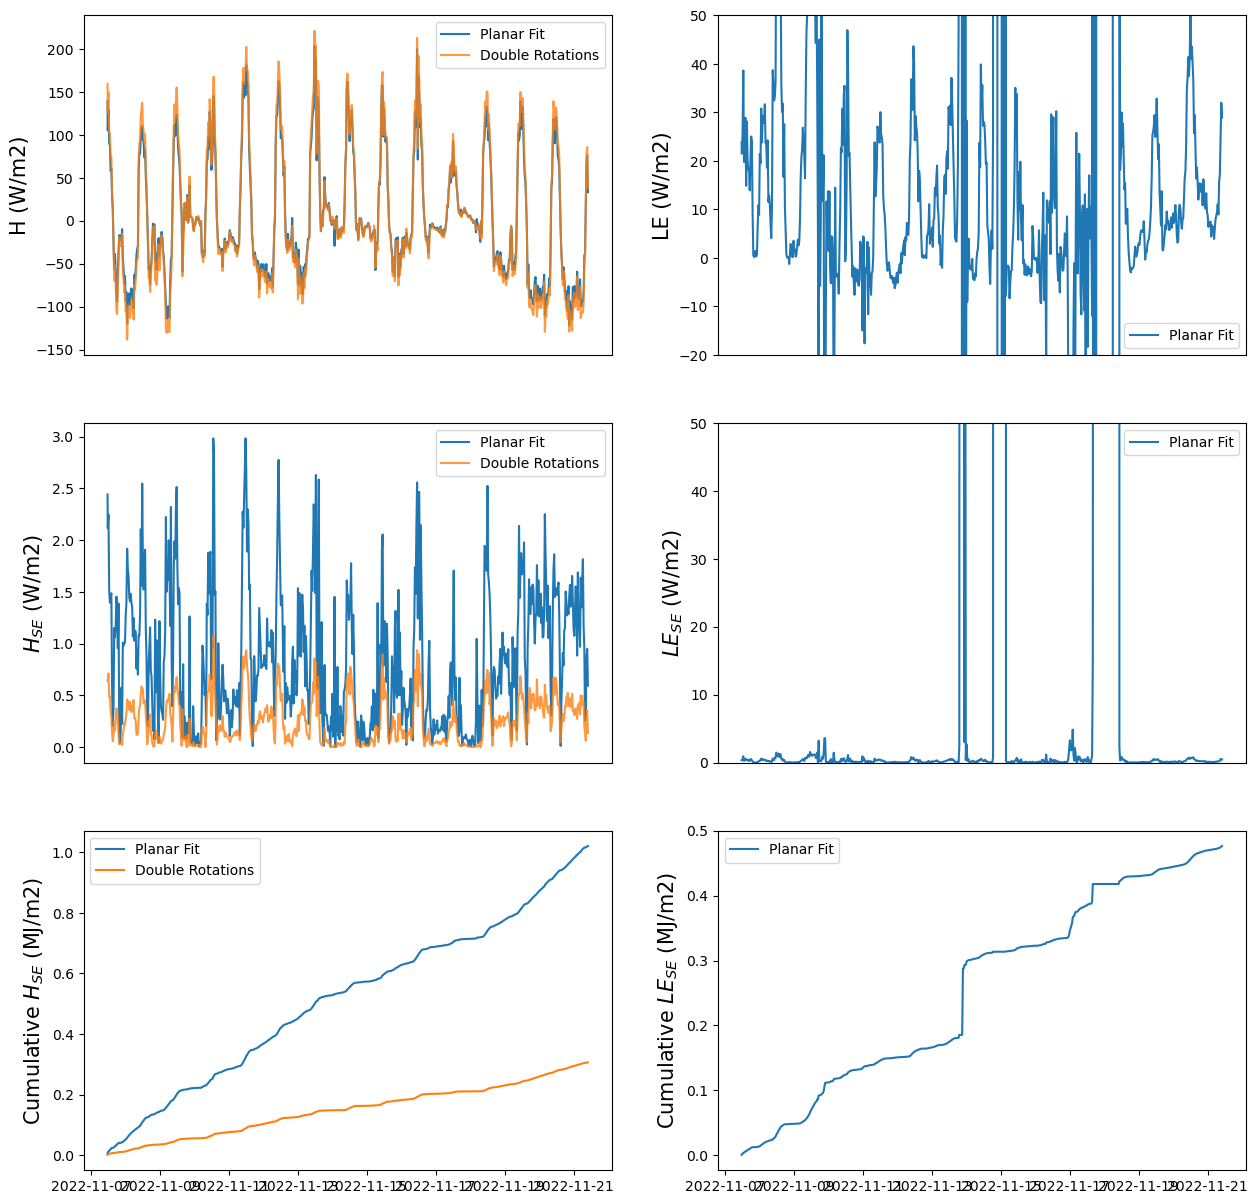

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
ts = axs[:, 0]
sc = axs[:, 1]

ts[0].plot(EC_7m_df.index, H_pf, label='Planar Fit')
ts[0].plot(EC_7m_df.index, H_wilczak, alpha=0.8, label='Double Rotations')
ts[0].set_ylabel('H (W/m2)', fontsize=15)
ts[0].legend()

sc[0].plot(EC_7m_df.index, LE_pf, label='Planar Fit')
sc[0].set_ylabel('LE (W/m2)', fontsize=15)
sc[0].set_ylim(-20, 50)
sc[0].legend()

ts[1].plot(EC_7m_df.index, eps_H_pf, label='Planar Fit')
ts[1].plot(EC_7m_df.index, eps_H_wilczak, alpha=0.8, label='Double Rotations')
ts[1].set_ylabel('$H_{SE}$ (W/m2)', fontsize=15)
ts[1].legend()

sc[1].plot(EC_7m_df.index, eps_LE_pf, label='Planar Fit')
sc[1].set_ylabel('$LE_{SE}$ (W/m2)', fontsize=15)
sc[1].set_ylim(0, 50)
sc[1].legend()

ts[2].plot(EC_7m_df.index, eps_H_pf.cumsum()*1800/1e6, label='Planar Fit')
ts[2].plot(EC_7m_df.index, eps_H_wilczak.cumsum()*1800/1e6, label='Double Rotations')
ts[2].set_ylabel('Cumulative $H_{SE}$ (MJ/m2)', fontsize=15)
ts[2].legend()

sc[2].plot(EC_7m_df.index, np.where(eps_LE_pf < 100, eps_LE_pf, 0).cumsum()*1800/1e6, label='Planar Fit')
sc[2].set_ylabel('Cumulative $LE_{SE}$ (MJ/m2)', fontsize=15)
sc[2].legend()

for ax in axs.flatten()[:-2]:
    ax.set_xticks([])

Due to uncertainty in anemometer tilt angle fit, sensible heat flux uncertainty ranges from 0 to 30 W/m2, and latent heat flux ranges from 0 to 20 W/m2. Cumulative uncertainty could be as high as 10 MJ/m2 for sensible heat flux, and 3.4 MJ/m2 for latent heat flux over a 20-day period in November. Uncertainty measured using the double rotations method, however, is about 10-20x smaller. I'm not sure why this is: it could be my own error.

Now, Wilczak (2001) says that this uncertainty could be up to 9% per degree of tilt error. My planar fit application seems to overestimate this error, but the double rotations method does not. This may be because the planar fit correction considers errors in U, V, and W, whereas the double-rotations method I used only considers errors due to rotations in the xz-plane.

(0.0, 200.0)

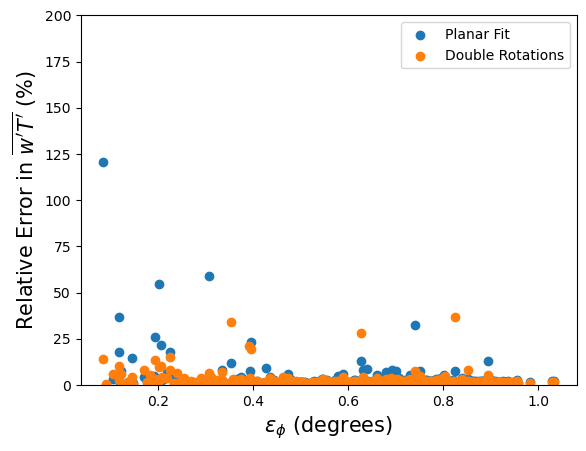

In [9]:
plt.scatter(eps_phi_wilczak*180/np.pi, eps_WT_pf/np.abs(Cov_WT_pf)*100, label='Planar Fit')
plt.scatter(eps_phi_wilczak*180/np.pi, eps_WT_pf/np.abs(Cov_WT_wilczak)*100, label='Double Rotations')
plt.legend()
plt.ylabel('Relative Error in $\overline{w\'T\'}$ (%)', fontsize=15)
plt.xlabel('$\epsilon_\phi$ (degrees)', fontsize=15)
plt.ylim(0, 200)

This approach is far from perfect: the data I performed this analysis on were not screened for missing values or spikes, and no other corrections were applied. If corrections for air density fluctuations for example were applied, these results could change significantly. However, these results seem to be within the ballpark provided by Wilczak (2001).